##### Cargue de librerias

In [1]:
from pycaret.clustering import *

import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint

import warnings
warnings.filterwarnings("ignore")

##### Conexion al DWH de Dispapeles y cargue de bds adicionales

In [2]:
## Conexion al DWH
cnxn = pyodbc.connect(
    driver='{SQL Server}',
    server='192.168.100.58',
    uid='bilectura',
    pwd='D1sp@p3l3s')
cursor = cnxn.cursor()
#cnxn.close()

In [3]:
# Consulta SQL para descargar la informacion a usar
codigo_SQL = "SELECT A.DSTCOD AS 'Codigo distrito', B.VNDZNA AS 'Codigo zona actual', CONCAT(CONCAT(A.VTANIT,'-'),A.VTASUC) AS 'Nit cliente-sucursal', A.VTAANO AS 'Ano', A.VTAMES AS 'Mes', (((2021 - MAX(A.VTAANO)) * 12 ) + (0 - MAX(A.VTAMES))) * -1 AS 'Recency', SUM(A.VTAVLRVTA) AS 'Monetary', COUNT( DISTINCT A.VTAMES) AS 'Frequency' FROM V_VTA_VTAHEC A LEFT JOIN	DIM_CLIENTES B ON A.PRMCOD = B.PRMCOD AND A.DSTCOD = B.DSTCOD AND A.VTANIT = B.CLTNIT AND A.VTASUC = B.CLTSUC WHERE A.PRMCOD = 1 AND A.DSTCOD NOT IN (30,35) AND A.VTAZNA < 96 AND A.VTAFCH BETWEEN '2021-01-01' AND '2022-12-31' GROUP BY A.DSTCOD, B.VNDZNA, CONCAT(CONCAT(A.VTANIT,'-'),A.VTASUC),	A.VTAANO, A.VTAMES HAVING SUM(A.VTAVLRVTA) > 0"

In [4]:
#Cargue de la data desde el ERP de Dispapeles y se guarda en df
cursor.execute(codigo_SQL)
rows = cursor.fetchall()
df = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

In [5]:
# Consulta adicional para establecer el tipo de zona
maestra_zonas = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/Análisis clustering/Maestra_zonas.csv', delimiter= ";")

##### Tranformaciones

In [7]:
# Conversion de tipo de la columna Monetary
df["Monetary"] = df["Monetary"].astype(int)

# Join con la maestra de zonas para determinar el tipo de zona
df_2 = pd.merge(df, maestra_zonas, on= ["Codigo distrito", "Codigo zona actual"])

# Filtro de la informacion para excluir zonas no relevantes
list_filter = ['Artes graficas', 'TIG', 'V Horeca', 'Institucional', 'V SyE',
                'V Industria', 'Mayorista']
df = df_2[df_2["Nombre tipo zona"].isin(list_filter)]

# DF final agregada por tipo de zona
df_3 = df.groupby(["Codigo distrito", "Nombre tipo zona", "Nit cliente-sucursal"]).agg({"Recency": np.max,
                                                                            "Monetary": np.sum,
                                                                            "Frequency": np.sum
                                                                            })
df_3 = df_3.reset_index(col_level= 1)

In [8]:
# Se añade una key de Distrito-Nombretipozona para hacer mas facil la identificacion cuando se usa todo el pais
# Se genera la calificacion de Recency basado en los valores máximos
# Se divide por millón la columna Monetary para disminuir el rango de los valores
df_3['Distrito-Nombretipozona'] = df_3['Codigo distrito'].astype(str) + '-' + df_3['Nombre tipo zona']
df_3['Monetary'] = (df_3['Monetary'] / 1000).astype(int)
df_3['Frequency'] = (df_3['Frequency']).astype(int)

##### Creacion, ajuste y descarga de los modelos de clustering por cada distrito-tipo de zona

In [9]:
list_dtos = df_3["Distrito-Nombretipozona"].unique()
numeric_features = ["Recency", "Monetary", "Frequency"]
ignore_columns = ["Codigo distrito", "Nombre tipo zona", "Nit cliente-sucursal", "Distrito-Nombretipozona"]
normalizar = [False, True]

##### Dos modelos, norm= True y norm= False

In [32]:
# Variables iniciales
bd_predicted = pd.DataFrame([])
metrics = []

# Fecha para guardar resultados
fecha = '14-2-23'

# Ciclo para realizar el modelo de clustering por cada tipo de zona del pais
for norm in normalizar:
    for n, dto in enumerate(list_dtos):
        print(f"Procesando modelo normalizado {norm} {n+1} de {len(list_dtos)}. {(n+1) / (len(list_dtos)):.1%}")
        
        #BD filtrada
        df_dto = df_3[df_3["Distrito-Nombretipozona"] == dto]
        
        #Setup del modelo 
        s = setup(
                    df_dto,
                    normalize = norm,
                    verbose= False,
                    preprocess= False,
                    silent= True,
                    profile= False,
                    ignore_features= ignore_columns,
                    numeric_features= numeric_features
                    )
        
        #Creacion y prediccion de modelo
        model_kmeans = create_model(
                                    'kmeans',
                                    num_clusters= 5,
                                    verbose= False,
                                    )
        pull()
        df_pred_km = predict_model(
                                    model_kmeans,
                                    data = df_dto
                                    )
        
        # Reasignacion de los nombres de los clusters
        trans = df_pred_km.groupby(
                                    ["Cluster"]).agg({
                                                    "Recency": np.mean, "Monetary": np.mean, "Frequency": np.mean,
                                                    }).sort_values(
                                                                    by= ["Monetary", "Frequency", "Recency"],
                                                                    ascending= False
                                                                    ).reset_index()
        trans["Letra cluster"] = ["A", "B", "C", "D", "E"]
        trans = trans[["Cluster", "Letra cluster"]]
        
        df_pred_km = pd.merge(df_pred_km, trans, on= ["Cluster"])
        
        # Descarga del modelo
        bd_predicted = bd_predicted.append(df_pred_km)

        #Append a la variable incial de metricas
        metrics.append({
                        "Distrito-zona": dto,
                        "Normalizado": norm,
                        "Silhouette": pull().Silhouette[0],
                        "Calinski-Harabasz": pull()["Calinski-Harabasz"][0],
                        "Davies-Bouldin": pull()["Davies-Bouldin"][0]
                        })
        # save_model(model_kmeans, f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Modelos {fecha}/Modelo {dto} {fecha}")

# Transformacion de la variable de metricas
metrics = pd.DataFrame(metrics)
metrics["Normalizado"] = metrics["Normalizado"].replace([True, False], ["Si","No"])
metrics["Tipo zona"] = metrics["Distrito-zona"].str[3:]

print("Proceso completo 100%")

Procesando modelo normalizado False 1 de 67. 1.5%
Procesando modelo normalizado False 2 de 67. 3.0%
Procesando modelo normalizado False 3 de 67. 4.5%
Procesando modelo normalizado False 4 de 67. 6.0%
Procesando modelo normalizado False 5 de 67. 7.5%
Procesando modelo normalizado False 6 de 67. 9.0%
Procesando modelo normalizado False 7 de 67. 10.4%
Procesando modelo normalizado False 8 de 67. 11.9%
Procesando modelo normalizado False 9 de 67. 13.4%
Procesando modelo normalizado False 10 de 67. 14.9%
Procesando modelo normalizado False 11 de 67. 16.4%
Procesando modelo normalizado False 12 de 67. 17.9%
Procesando modelo normalizado False 13 de 67. 19.4%
Procesando modelo normalizado False 14 de 67. 20.9%
Procesando modelo normalizado False 15 de 67. 22.4%
Procesando modelo normalizado False 16 de 67. 23.9%
Procesando modelo normalizado False 17 de 67. 25.4%
Procesando modelo normalizado False 18 de 67. 26.9%
Procesando modelo normalizado False 19 de 67. 28.4%
Procesando modelo normaliza

##### Un solo modelo, norm= False

In [ ]:
bd_predicted = pd.DataFrame([])
metrics = []
fecha = '1-2-23'

for n, dto in enumerate(list_dtos):
    print(f"Procesando modelo {n+1} de {len(list_dtos)}. {(n+1) / (len(list_dtos)):.1%}")
    
    #BD filtrada
    df_dto = df_3[df_3["Distrito-Nombretipozona"] == dto]
    
    #Setup del modelo 
    s = setup(
                df_dto,
                normalize = False,
                verbose= False,
                preprocess= False,
                silent= True,
                profile= False,
                ignore_features= ignore_columns,
                numeric_features= numeric_features
                )
    
    #Creacion y prediccion de modelo
    model_kmeans = create_model(
                                'kmeans',
                                num_clusters= 5,
                                verbose= False,
                                )
    pull()
    df_pred_km = predict_model(
                                model_kmeans,
                                data = df_dto
                                )
    
    # Reasignacion de los nombres de los clusters
    trans = df_pred_km.groupby(
                                ["Cluster"]).agg({
                                                "Recency": np.mean, "Monetary": np.mean, "Frequency": np.mean,
                                                }).sort_values(
                                                                by= ["Recency", "Frequency", "Monetary"],
                                                                ascending= False
                                                                ).reset_index()
    trans["Letra cluster"] = ["A", "B", "C", "D", "E"]
    trans = trans[["Cluster", "Letra cluster"]]
    
    df_pred_km = pd.merge(df_pred_km, trans, on= ["Cluster"])
    
    # Descargue del modelo
    bd_predicted = bd_predicted.append(df_pred_km)

    #Append a una base general
    metrics.append({
                    "Distrito-zona": dto,
                    "Silhouette": pull().Silhouette[0],
                    "Calinski-Harabasz": pull()["Calinski-Harabasz"][0],
                    "Davies-Bouldin": pull()["Davies-Bouldin"][0]
                    })
    # save_model(model_kmeans, f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Modelos {fecha}/Modelo {dto} {fecha}")

metrics = pd.DataFrame(metrics)
metrics["Tipo zona"] = metrics["Distrito-zona"].str[3:]

print("Proceso completo 100%")

##### Visualizacion y validacion clustering

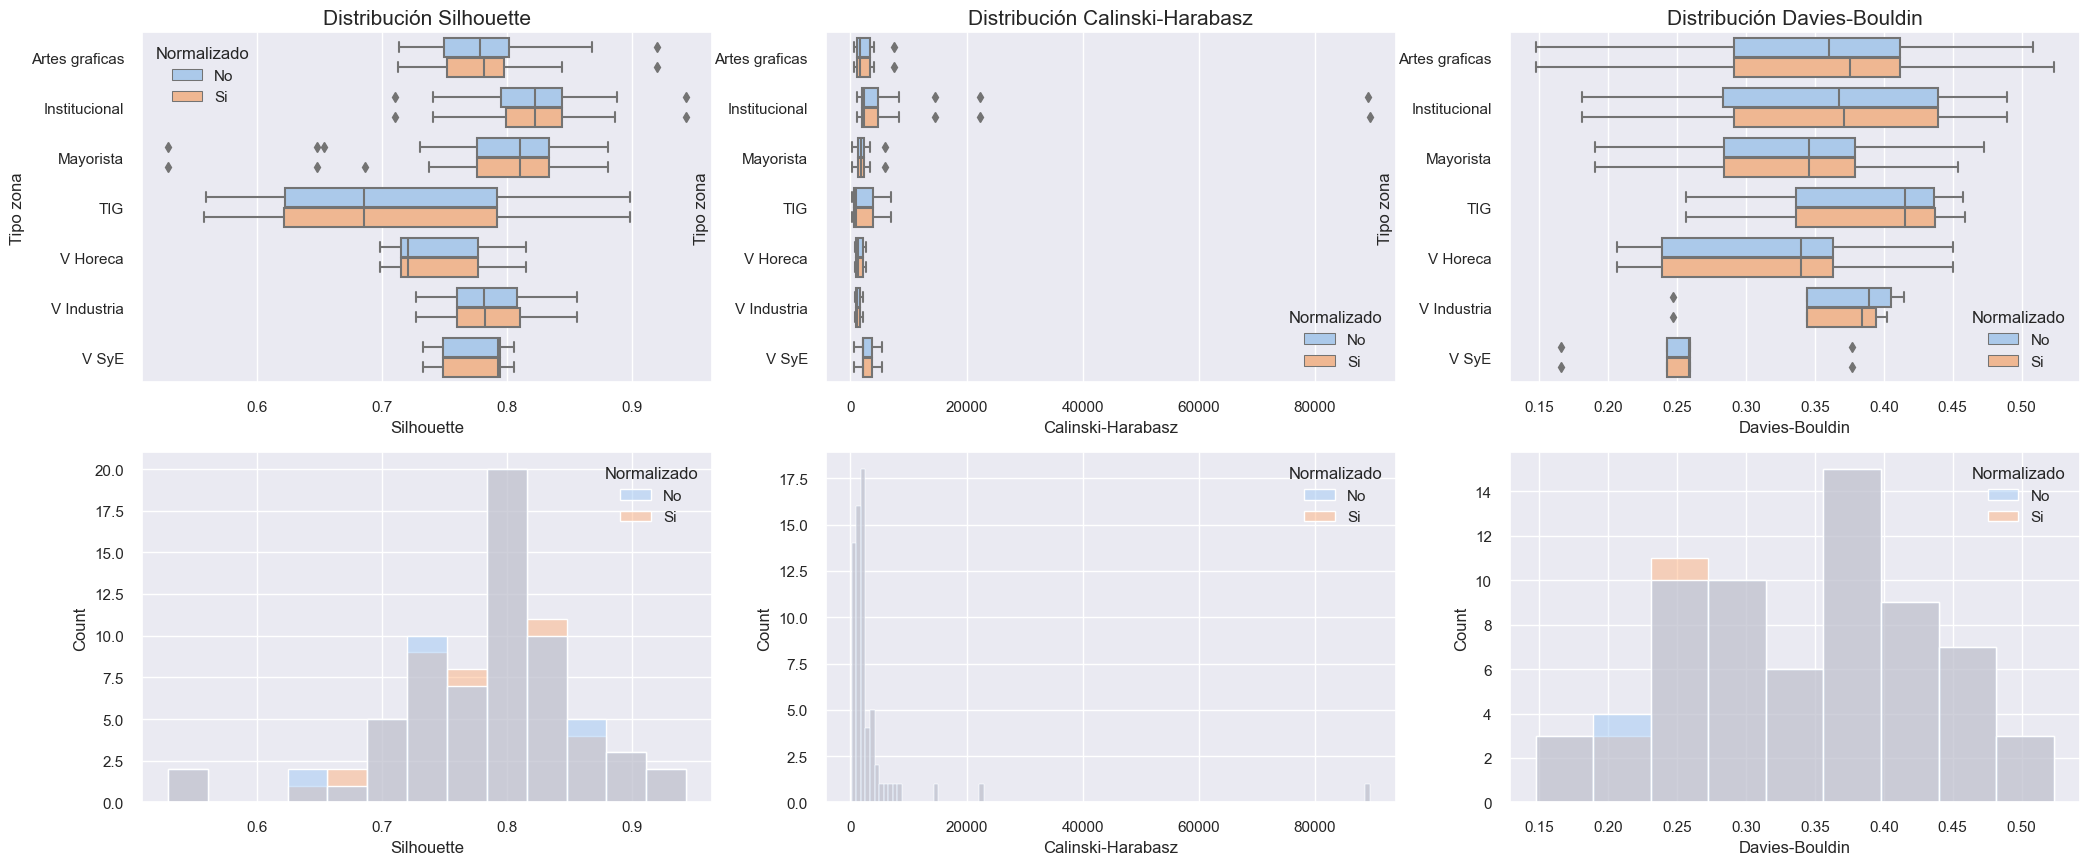

In [33]:
# Plots para validar si hay diferencia o no entre la data normalizada o no
f, axarr = plt.subplots(2,3)
f.set_figheight(10)
f.set_figwidth(25)

metricas = ["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]

for n, met in enumerate(metricas):
    f.add_subplot(axarr[0,n])
    plt.title(f"Distribución {met}").set_fontsize(15)
    sns.set_theme(style="darkgrid", palette= "pastel")
    sns.boxplot(data= metrics, x= met, y= "Tipo zona", hue= 'Normalizado')

    f.add_subplot(axarr[1,n])
    sns.set_theme(style="darkgrid", palette= "pastel")
    sns.histplot(data= metrics, x= met, hue= 'Normalizado')
plt.show()



In [14]:
# Describe de las metricas normalizadas
metrics[metrics['Normalizado'] == "Si"].describe()

,Silhouette,Calinski-Harabasz,Davies-Bouldin
count,67.000000,67.000000,67.000000
mean,0.784937,4076.055013,0.340652
std,0.072697,11135.278268,0.089722
min,0.528600,233.687700,0.147600
25%,0.743250,1195.295250,0.271350
50%,0.795300,2011.514200,0.357900
75%,0.826900,3165.974150,0.416800
max,0.943700,89846.610900,0.512000


In [15]:
# Describe de las metricas NO normalizadas
metrics[metrics['Normalizado'] == "No"].describe()

,Silhouette,Calinski-Harabasz,Davies-Bouldin
count,67.000000,67.000000,67.000000
mean,0.784479,4076.099109,0.344652
std,0.072330,11128.520551,0.093277
min,0.528600,233.687700,0.147600
25%,0.744700,1195.295250,0.271350
50%,0.795300,2011.514200,0.352900
75%,0.823450,3168.914300,0.416900
max,0.943700,89784.107400,0.523200


In [34]:
# Descarga de bd predicha y metricas calculadas
bd_predicted.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Clustering {fecha}.csv",
                        encoding= 'utf-8', index= False, decimal= ",", sep= ";")
metrics.to_csv(f"C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Metricas {fecha}.csv",
                        encoding= 'utf-8', index= False, decimal= ",",  sep= ";")

In [35]:
df_pred_km

,Codigo distrito,Nombre tipo zona,Nit cliente-sucursal,Recency,Monetary,Frequency,Distrito-Nombretipozona,Cluster,Letra cluster
0,90,Mayorista,1007934252-1,14,2144,5,90-Mayorista,Cluster 3,E
1,90,Mayorista,10091164-1,17,10290,1,90-Mayorista,Cluster 3,E
2,90,Mayorista,100934252-1,10,205,1,90-Mayorista,Cluster 3,E
3,90,Mayorista,1055916959-1,17,5007,8,90-Mayorista,Cluster 3,E
4,90,Mayorista,1070586102-1,24,868,1,90-Mayorista,Cluster 3,E
...,...,...,...,...,...,...,...,...,...
131,90,Mayorista,901391713-1,24,434553,17,90-Mayorista,Cluster 4,C
132,90,Mayorista,809011022-1,24,2432909,24,90-Mayorista,Cluster 1,A
133,90,Mayorista,900241288-1,24,788702,24,90-Mayorista,Cluster 2,B
134,90,Mayorista,900363900-1,24,631901,23,90-Mayorista,Cluster 2,B


Text(0.5, 0, 'Frequency')

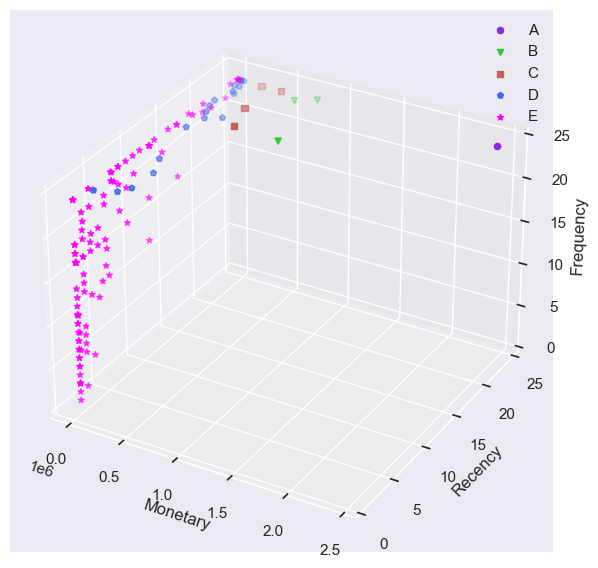

In [37]:
# Visualizacion de las 
fig = plt.figure(figsize=(7,10))
ax = fig.gca(projection='3d')

m = ['o', 'v', 's', 'p', '*']
col =  ['blueviolet', 'limegreen', 'indianred', 'royalblue', 'magenta']
# leg = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3', 'Cluster 4']
leg = ['A', 'B', 'C', 'D', 'E']
cluster = list(np.unique(df_pred_km['Letra cluster']))

for c in range(5):
    df_plot = df_pred_km[df_pred_km['Letra cluster'] == cluster[c]]
    ax.scatter(df_plot['Monetary'],df_plot['Frequency'], df_plot['Recency'] , marker= m[c], c= col[c])
    
ax.legend(leg)
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

In [38]:
plot_model(model_kmeans, plot = 'cluster')

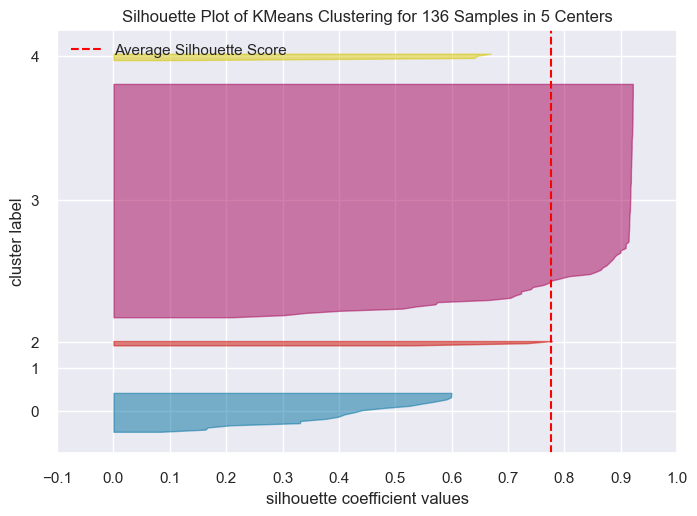

In [39]:
plot_model(model_kmeans, plot = 'silhouette')

In [40]:
plot_model(model_kmeans, plot = 'distribution')